In [1]:
%matplotlib widget

In [2]:
import numpy as np
from scipy.constants import c as clight
import xtrack as xt
import xobjects as xo
import matplotlib.pyplot as plt

In [3]:
line = xt.Line.from_json('../PIMMStutorials_CNAOlattice/cnao_lattice_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/429 [00:00<?, ?it/s]

Done loading line from dict.           


### Define reference particle

In [4]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=60e6)

### Match

In [5]:
# Build a single match with all constraints (can be reused to retune the machine)
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['s0', 's1'], step=1e-3, tag = 'sext'),
        xt.VaryList(['kf', 'kd','kr'], limits=(0, 1),  step=1e-3, tag='quad')
    ],
    targets=[
        xt.TargetSet(dqx=-4, dqy=-1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='symp', tol=1e-6),
        xt.TargetSet(qx=1.666, qy=1.74, tol=1e-6),
    ]
)
# Perform twenty optimization steps
opt.step(20)

                                             
Optimize - start penalty: 4.082         
Matching: model call n. 22               
Optimize - end penalty:  4.11888e-06


### Twiss

In [6]:
tw = line.twiss(method='4d')

### Build a matched beam distribution

In [7]:
# Define number of turns and number of particles for the simulation
num_turns = 5000
num_particles = 1500
beam_intensity = 1e10 # p+

# Generate Gaussian distribution in normalized phase space
x_norm = np.random.normal(size=num_particles)
px_norm = np.random.normal(size=num_particles)
y_norm = np.random.normal(size=num_particles)
py_norm = np.random.normal(size=num_particles)

# Generate Gaussian momentum offset distribution (mean 6e-4, std spread 1e-4)
delta = np.random.normal(loc=6e-4, scale=1e-4, size=num_particles)

# Particles arrival time spread over one turn
zeta = np.random.uniform(low=-0.5, high=0.5, size=num_particles) * line.get_length()

# Assemble Particles object
particles = line.build_particles(
    x_norm=x_norm, px_norm=px_norm, 
    y_norm=y_norm, py_norm=py_norm,
    delta=delta,
    zeta=zeta,
    method='4d',
    weight=beam_intensity / num_particles,
    nemitt_x=0.52e-6, nemitt_y=1e-8,
)

# save initial state
p0 = particles.copy()

In [8]:
# Get details for existing RFKO exciter element in CNAO lattice
tab = line.get_table()
myRow=tab.rows['sb_011a_shv']
myRow.cols['s','name','element_type','s_start','s_end','s_center']

Table: 1 row, 6 cols
name                    s element_type       s_start         s_end      s_center
sb_011a_shv       63.1856 Drift              63.1856       63.6866       63.4361

### Define time-dependent bevior of extraction sextupole

In [9]:
line.functions['fun_xsext'] = xt.FunctionPieceWiseLinear(x=[0, 0.1e-3, 0.5e-3], y=[0, 0, 1.])

line.vars['sr'] *= line.functions['fun_xsext'](line.vars['t_turn_s'])

# Inspect the expression
line.vars['sr']._expr

(-3.3015954716218534 * f['fun_xsext'](vars['t_turn_s']))

### Set realistic septum aperture

In [10]:
line['septum_aperture'].max_x = 0.035

### Switch to multithreaded context to gain speed

In [11]:
line.discard_tracker()
ctx = xo.ContextCpu(omp_num_threads='auto')
line.build_tracker(_context=ctx)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


### Define quantities to be logged during tracking

In [12]:
# User-defined quantity to be logged (functions executed at every turn, output is automatically logged).
def measure_intensity(line, particles):
    mask_alive = particles.state > 0
    intensity = np.sum(particles.weight[mask_alive])
    return intensity

log = xt.Log('sr',              # vars to be logged
             intensity=measure_intensity) # user-defined function to be logged

### Enable time-dependent vars update for tracking

In [13]:
line.enable_time_dependent_vars = True

### Introduce transverse excitation to control the spill

We build a custom beam element that excites the beam with a sinusoidal function **of time**

In [14]:
# Define new element type
class RFKOExciter:
    def __init__(self):
        
        self.amplitude = 0
        self.tune = 0
        self.f_rev = 1 / tw.T_rev0

    def track(self, p):

        f_excit = self.tune * self.f_rev

        # Time of arrival corrected for delay within the turn
        t_particle_pass = (p.at_turn[p.state > 0] / self.f_rev
                              - p.zeta[p.state > 0] / p.beta0[0] / clight) 

        p.px[p.state > 0] += (
            self.amplitude * np.sin(2 * np.pi * f_excit * t_particle_pass))
        

**NOTE:** p.zeta is the longitudinal position of each particle along the length of the lattice.
In the RFKOExciter class we calculate the time at which each particle passes from the exciter.
This time is saved in the variable t_particle_pass.


### Introduce RF Cavity

In [15]:
# Set an RF Cavity element with Voltage=1kV, Frequency=revolution frequency and lag=0 (no acceleration)
f_rev = 1 / tw.T_rev0
rf_cavity = xt.Cavity(voltage=1e3, frequency=f_rev, lag=0)

In [16]:
# Install the elements
line.discard_tracker()

line.remove('s8_020a_cav')
line.insert('rf_cavity', rf_cavity, at=49.2291)

line.insert_element('rfko_exc', RFKOExciter(), at_s=63.4361)

line.build_tracker(_context=ctx)

Slicing line:   0%|          | 0/429 [00:00<?, ?it/s]

Slicing line:   0%|          | 0/431 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


Use the amplitude and the frequency of the excitation to control the spill

In [17]:
min_freq = 0.662
max_freq = 0.665

In [18]:
# Define a function that activates the exciter amplitude after 1.5e-3 seconds
line.functions['fun_excit'] = xt.FunctionPieceWiseLinear(
    x=[0, 1.5e-3, 1.50001e-3],
    y=[0, 0, 2e-5])

# Define a function that linearly increases the exciter frequency from 1.5e-3 until the end of the simulation
line.functions['fun_freq'] = xt.FunctionPieceWiseLinear(
    x=[0,     1.5e-3, tw.T_rev0 * num_turns],
    y=[min_freq , min_freq,  max_freq])

line.vars['ampl_excit'] = line.functions['fun_excit'](line.vars['t_turn_s'])
line.vars['freq_excit'] = line.functions['fun_freq'](line.vars['t_turn_s'])

line.element_refs['rfko_exc'].amplitude = line.vars['ampl_excit']
line.element_refs['rfko_exc'].tune = line.vars['freq_excit']

### Reset the model

In [19]:
# Reset simulation time
line.vars['t_turn_s'] = 0

### Log excitation parameters

In [20]:
log = xt.Log(
    'sr', 't_turn_s',                                         # vars to be logged
    'ampl_excit', 'freq_excit', intensity=measure_intensity)  # user-defined functions to be logged

### Track!

In [21]:
line.track(p0, num_turns=num_turns, with_progress=True, turn_by_turn_monitor=True,
           log=log)

Tracking:   0%|          | 0/5000 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [22]:
# Record particle coordinates turn by turn
rec = line.record_last_track
# Get turn by turn normalized coordinates 
nc2 = tw.get_normalized_coordinates(rec)

/home/aefstrat/miniforge3/lib/python3.12/site-packages/xtrack/twiss.py:3238: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


### Plot logged quantities

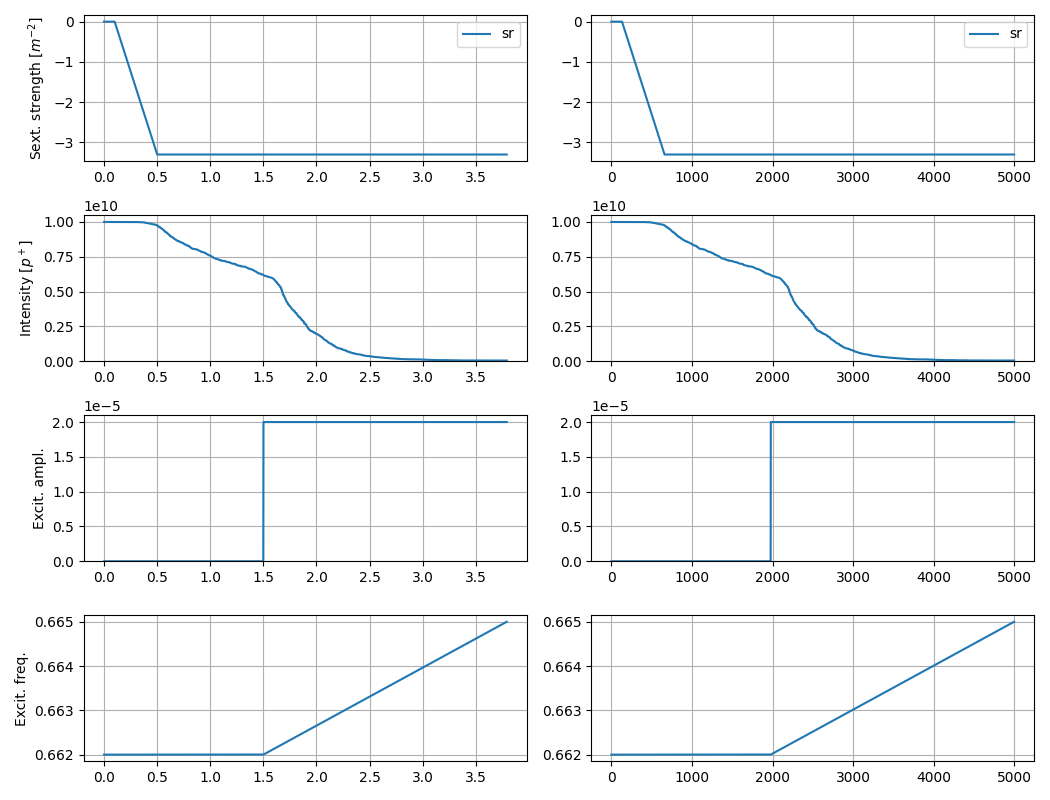

In [23]:
plt.figure(figsize=(10.5, 8))

t_ms = np.array(line.log_last_track['t_turn_s']) * 1e3

ax1 = plt.subplot(4,2,1)
plt.plot(t_ms, line.log_last_track['sr'], label='sr')
plt.ylabel('Sext. strength [$m^{-2}$]')
plt.legend()
plt.grid()

ax2 = plt.subplot(4,2,2)
plt.plot(line.log_last_track['sr'], label='sr')
plt.legend()
plt.grid()

ax3 = plt.subplot(4,2,3, sharex=ax1)
plt.plot(t_ms, line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.ylabel('Intensity [$p^+$]')
plt.grid()

ax4 = plt.subplot(4,2,4, sharex=ax2)
plt.plot(line.log_last_track['intensity'])
plt.ylim(bottom=0)
plt.grid()

ax5 = plt.subplot(4,2,5, sharex=ax1)
plt.plot(t_ms, line.log_last_track['ampl_excit'])
plt.ylim(bottom=0)
plt.ylabel('Excit. ampl.')
plt.grid()

ax6 = plt.subplot(4,2,6, sharex=ax2)
plt.plot(line.log_last_track['ampl_excit'])
plt.ylim(bottom=0)
plt.grid()

ax7 = plt.subplot(4,2,7, sharex=ax1)
plt.plot(t_ms, line.log_last_track['freq_excit'])
plt.ylabel('Excit. freq.')
plt.grid()

ax8 = plt.subplot(4,2,8, sharex=ax2)
plt.plot(line.log_last_track['freq_excit'])
plt.grid()

plt.tight_layout()

In [24]:
# Alive percentage after tracking with RFKO exciter and resonance sextupole ramp-up
print(f"Percentage of alive particles after RFKO:\n{100*(line.log_last_track["intensity"][-1] / beam_intensity)} %")

Percentage of alive particles after RFKO:
0.4666666666666666


### Plot particles after tracking

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


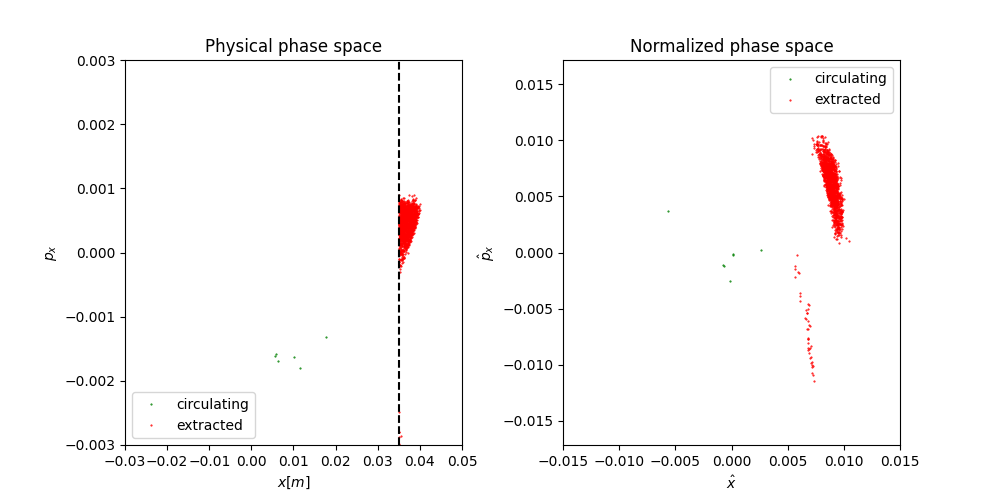

In [25]:
mask_alive2 = p0.state>0
mask_lost2 = ~mask_alive2

# Get particles normalized coordinates
p_nc = tw.get_normalized_coordinates(p0)

plt.figure(figsize=(10, 5))
ax_g = plt.subplot(1, 2, 1, title='Physical phase space')
ax_n = plt.subplot(1, 2, 2, title='Normalized phase space')

ax_g.plot(p0.x[mask_alive2], p0.px[mask_alive2],
         '.', markersize=1, color='green', label='circulating')
ax_g.plot(p0.x[mask_lost2], p0.px[mask_lost2],
         '.', markersize=1, color='red', label='extracted')
ax_g.set_xlim(-0.03, 0.05); ax_g.set_ylim(-3e-3, 3e-3)
ax_g.axvline(x=line['septum_aperture'].max_x, color='k', ls='--')
ax_g.set_xlabel(r'${x} [m]$')
ax_g.set_ylabel(r'${p}_x$')
ax_g.legend()

ax_n.plot(p_nc.x_norm[mask_alive2], p_nc.px_norm[mask_alive2],
         '.', markersize=1, color='green', label='circulating')
ax_n.plot(p_nc.x_norm[mask_lost2], p_nc.px_norm[mask_lost2],
         '.', markersize=1, color='red', label='extracted')
ax_n.set_xlim(-0.015, 0.015); ax_n.set_ylim(-0.01, 0.01)
ax_n.set_aspect('equal', adjustable='datalim')
ax_n.set_xlabel(r'$\hat{x}$')
ax_n.set_ylabel(r'$\hat{p}_x$')
ax_n.legend()

plt.subplots_adjust(wspace=0.3)

plt.show()

In [26]:
# Extracted particles' px spread at electrostatic septum in mrad
print(f'Maximum px spread of extracted beam:\n{(p0.px[mask_lost2].max() - p0.px[mask_lost2].min()) * 1e3} mrad')

Maximum px spread of extracted beam:
5.420671632592772


**NOTE above:** The maximum px spread at the electrostatic septum is so large because some particles are extracted from a second separatrix.

## Steinbach

In [27]:
# Convert to numpy array (in order to multiply)
sr = np.array(line.log_last_track['sr'])

# We calculate the normalized sextupole strength S (np array with a value for each turn)
norm_sext_strength = 0.5 * (tw['betx', 's8_028a_sxr'])**1.5 * line['s8_028a_sxr'].length * sr

**NOTE Below:** Because the momentum spread of the beam is very small or displaced from the resonance tune, we create a wider distribution to calculate the resonance lines with smaller size than the number of particles. This helps to calculate the resonance amplitude faster. 

** This may sacrifice a little bit the linearity of the line (with sample_size=200 we have a decent linearity and the calculation is fast enough)

In [28]:
# Define the size of the new distribution
sample_size = 200
# Create the new Gaussian distribution centered on resonance tune
delta2 = np.random.normal(loc= (5/3 - tw.qx) / tw.dqx, scale=17e-4, size = sample_size)

**NOTE Below:** In ``norm_amplitude`` after the loss of each particle we get a nan value for its remaining turns in the simulation.

In [29]:
res_amplitude = np.zeros((sample_size, num_turns))
for jj in range(0, num_turns):
    for ii in range(0, sample_size):
        # We calculate the resonance amplitude
        res_amplitude[ii,jj] = np.sqrt(48*np.pi*np.sqrt(3)) * np.abs(tw.dqx/norm_sext_strength[jj]) * np.abs(delta2[ii])

# We calculate the normalized amplitude for each particle and at every turn
# We get a 2D array of shape [num_particles, num_turns]

norm_amplitude = np.sqrt(nc2.x_norm**2 + nc2.px_norm**2)

/tmp/ipykernel_4951/1148114860.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  res_amplitude[ii,jj] = np.sqrt(48*np.pi*np.sqrt(3)) * np.abs(tw.dqx/norm_sext_strength[jj]) * np.abs(delta2[ii])


In [30]:
# Sort indices based on p.delta
sort_idx = np.argsort(delta2)

# Apply sorting to both arrays
res_tune_sorted = delta2[sort_idx] * tw.dqx + 5/3
amplitude_sorted = res_amplitude[sort_idx,:] 

Text(0, 0.5, 'Normalized Amplitude')

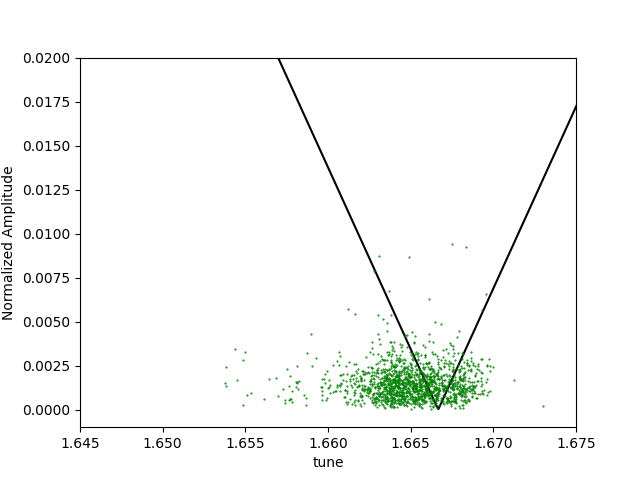

In [31]:
# We choose a turn to plot
turn = 500

# Plot for chosen turn
plt.figure()
plt.plot(res_tune_sorted, amplitude_sorted[:,turn], '-', markersize=1, color='k')
plt.plot(p0.delta * tw.dqx + tw.qx, norm_amplitude[:,turn], '.', markersize=1, color='g')
plt.xlim(1.645,1.675); plt.ylim(-1e-3,0.02)
plt.xlabel('tune')
plt.ylabel('Normalized Amplitude')

#### Animated Steinbach diagram for the whole simulation

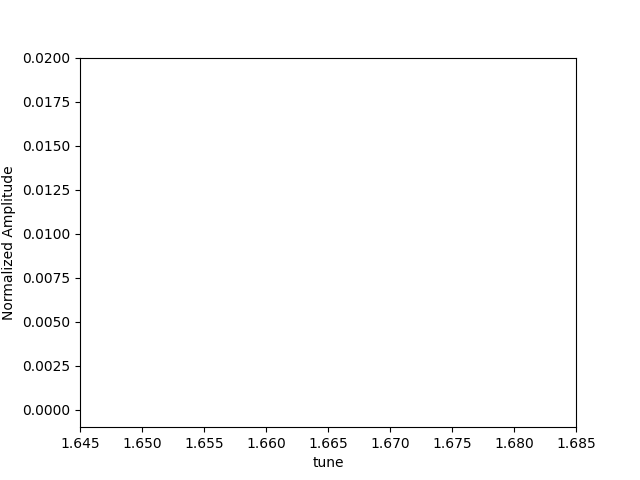

In [35]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
line, = ax.plot([], [], '.', markersize=1, color='g')
line2, = ax.plot([], [], '-', linewidth=1, color='k')
text_label = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax.set_xlim(1.645,1.685)
ax.set_ylim(-1e-3,0.02)
ax.set_xlabel("tune")
ax.set_ylabel("Normalized Amplitude")

# Update function for animation
def update(frame):
    line.set_data(rec.delta[:, frame] * tw.dqx + tw.qx, norm_amplitude[:, frame])
    line2.set_data(res_tune_sorted, amplitude_sorted[:, frame])
    if 135 <= frame <= 655:
        text_label.set_text(f'Turn {frame} - Sextupole Ramp Up and RF Cavity ON')
    elif 660 < frame < 1975 or frame < 135:
        text_label.set_text(f'Turn {frame} - RF Cavity ON')
    else:
        text_label.set_text(f'Turn {frame} - RFKO')
    return line, line2, text_label

ani = FuncAnimation(fig, update, frames=range(0, num_turns, 5), interval=30, blit=True, repeat=False)

plt.show()